In [50]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

In [51]:
# Download latest version of the data from Kaggle

import kagglehub

path = kagglehub.dataset_download("usdot/flight-delays")


In [52]:
#import glob

#airlines_raw_path = glob.glob(f'{path}/airlines.csv')

#airlines_raw_path

In [53]:
import glob

airlines_raw_path = glob.glob(f'{path}/airlines.csv')
airports_raw_path = glob.glob(f'{path}/airports.csv')
flights_raw_path = glob.glob(f'{path}/flights.csv')

airlines_raw = pd.read_csv(airlines_raw_path[0])
airports_raw = pd.read_csv(airports_raw_path[0])
flights_raw = pd.read_csv(flights_raw_path[0], low_memory=False)

In [54]:
df = flights_raw.merge(airports_raw, how='left',left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')\
    .merge(airports_raw, how='left',left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', suffixes=["_orig", "_dest"])\
    .merge(airlines_raw, how='left', left_on='AIRLINE', right_on='IATA_CODE')

df = df.drop(['AIRLINE_x'], axis=1)
df = df.rename(columns={"IATA_CODE": "AIRLINE_CODE", "AIRLINE_y": "AIRLINE"})

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE_orig,AIRPORT_orig,CITY_orig,STATE_orig,COUNTRY_orig,LATITUDE_orig,LONGITUDE_orig,IATA_CODE_dest,AIRPORT_dest,CITY_dest,STATE_dest,COUNTRY_dest,LATITUDE_dest,LONGITUDE_dest,AIRLINE_CODE,AIRLINE
0,2015,1,1,4,98,N407AS,ANC,SEA,5,2354.00,-11.00,21.00,15.00,205.00,194.00,169.00,1448,404.00,4.00,430,408.00,-22.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17,-150.00,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.45,-122.31,AS,Alaska Airlines Inc.
1,2015,1,1,4,2336,N3KUAA,LAX,PBI,10,2.00,-8.00,12.00,14.00,280.00,279.00,263.00,2330,737.00,4.00,750,741.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94,-118.41,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68,-80.10,AA,American Airlines Inc.
2,2015,1,1,4,840,N171US,SFO,CLT,20,18.00,-2.00,16.00,34.00,286.00,293.00,266.00,2296,800.00,11.00,806,811.00,5.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SFO,San Francisco International Airport,San Francisco,CA,USA,37.62,-122.37,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21,-80.94,US,US Airways Inc.
3,2015,1,1,4,258,N3HYAA,LAX,MIA,20,15.00,-5.00,15.00,30.00,285.00,281.00,258.00,2342,748.00,8.00,805,756.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94,-118.41,MIA,Miami International Airport,Miami,FL,USA,25.79,-80.29,AA,American Airlines Inc.
4,2015,1,1,4,135,N527AS,SEA,ANC,25,24.00,-1.00,11.00,35.00,235.00,215.00,199.00,1448,254.00,5.00,320,259.00,-21.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.45,-122.31,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17,-150.00,AS,Alaska Airlines Inc.


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 46 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   FLIGHT_NUMBER        int64  
 5   TAIL_NUMBER          object 
 6   ORIGIN_AIRPORT       object 
 7   DESTINATION_AIRPORT  object 
 8   SCHEDULED_DEPARTURE  int64  
 9   DEPARTURE_TIME       float64
 10  DEPARTURE_DELAY      float64
 11  TAXI_OUT             float64
 12  WHEELS_OFF           float64
 13  SCHEDULED_TIME       float64
 14  ELAPSED_TIME         float64
 15  AIR_TIME             float64
 16  DISTANCE             int64  
 17  WHEELS_ON            float64
 18  TAXI_IN              float64
 19  SCHEDULED_ARRIVAL    int64  
 20  ARRIVAL_TIME         float64
 21  ARRIVAL_DELAY        float64
 22  DIVERTED             int64  
 23  CANCELLED            int64  
 24

In [95]:
# This shows us that a couple of columns have problems with data type:

# "Flight number" is numeric, but that variable shouldn't be treated like a number. For example, we don't care what its sum is.
# "Origin airport" is listed as "object," which means it has both numeric and string values. 
#   (This is why we used "low_memory=False" when reading it.)
#   We would like both of these variables to be treated as strings.

df['FLIGHT_NUMBER'] = df['FLIGHT_NUMBER'].astype(str)
df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype(str)

# Now that "Origin airport" is string-only, we want to make sure it contains only 3-letter airport codes.

regex = r"[A-Z]{3}$"
is_valid_origin = df["ORIGIN_AIRPORT"].str.match(regex)
df = df[is_valid_origin]

In [96]:
# For ease of understanding the data, I will use only flights which begin and end in the USA.

df = df[(df['COUNTRY_orig'] == 'USA') & (df['COUNTRY_dest'] == 'USA')]

In [97]:
# There are lots of missing values (`NaN`) in the file. In this case we will fill those missing cases with 0

df = df.fillna(0).reset_index(drop = True)

In [98]:
# Create a variable to track if each flight was actually delayed

df['DELAY_EXISTS'] = np.where(df['ARRIVAL_DELAY'] > 0 , 1, 0)

In [99]:
# Isolate the variables we want to describe

vars_to_desc = ['DEPARTURE_DELAY', 'TAXI_OUT', 'AIR_TIME', 'DISTANCE', 
                'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
                'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DELAY_EXISTS']

summary_metrics = df[vars_to_desc].describe()
summary_metrics

,DEPARTURE_DELAY,TAXI_OUT,AIR_TIME,DISTANCE,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAY_EXISTS
count,5332914.00,5332914.00,5332914.00,5332914.00,5332914.00,5332914.00,5332914.00,5332914.00,5332914.00,5332914.00,5332914.00
mean,9.62,15.84,111.50,822.90,4.79,2.54,0.01,3.56,4.46,0.56,0.36
std,37.32,9.15,73.27,607.80,39.41,13.27,0.95,22.04,20.95,9.02,0.48
min,-82.00,0.00,0.00,21.00,-87.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-5.00,11.00,59.00,373.00,-13.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-1.00,14.00,93.00,649.00,-4.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,7.00,19.00,143.00,1065.00,8.00,0.00,0.00,0.00,0.00,0.00,1.00
max,1988.00,225.00,690.00,4983.00,1971.00,1134.00,573.00,1971.00,1331.00,1211.00,1.00


In [100]:
# Mean flight distance traveled

print(f"Average flight distance traveled: {df['DISTANCE'].mean().astype(int)} miles")

Average flight distance traveled: 822 miles


In [101]:
# How many airlines?

airline_list = df['AIRLINE'].unique()
print(f"Number of airlines: {len(airline_list)}")

Number of airlines: 14


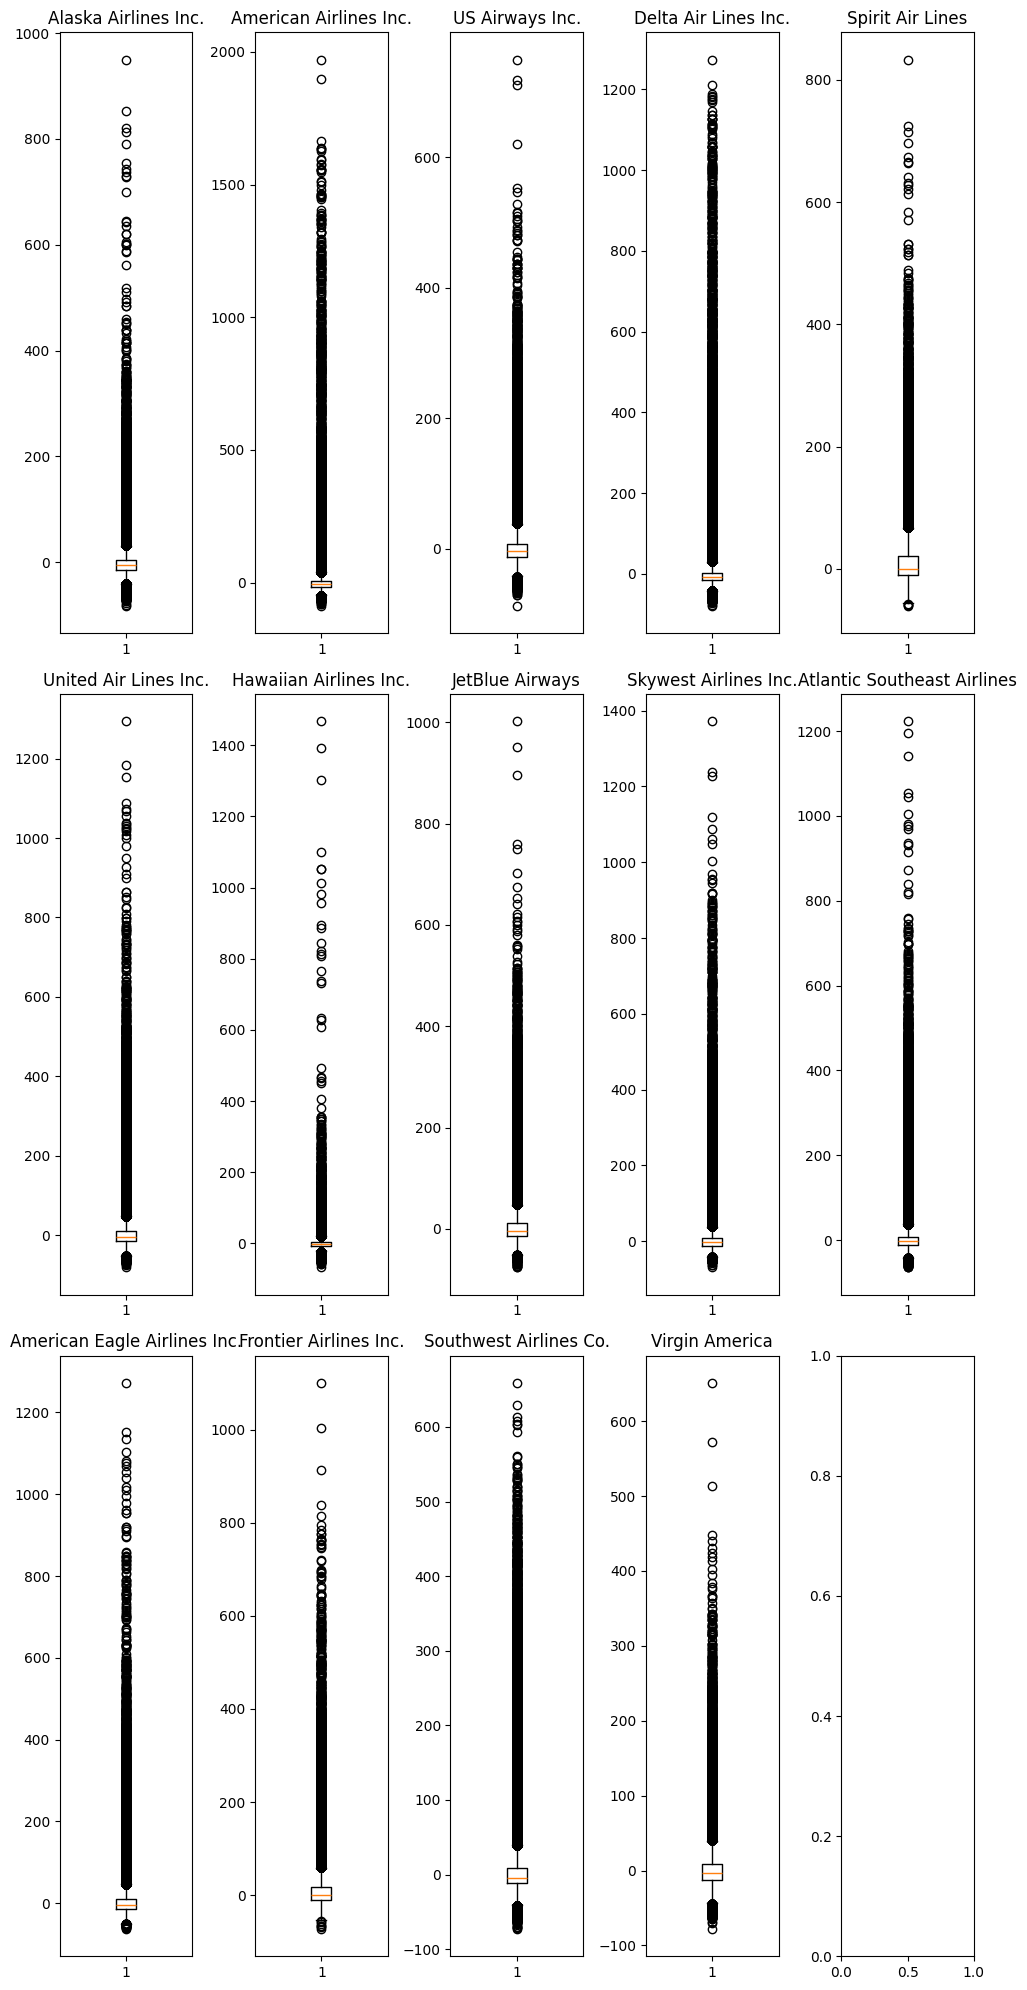

In [102]:
# Visualize the arrival delays by airline

fig, axes = plt.subplots(3, 5, figsize=(10, 20))

for i, ax in enumerate(axes.flat):
    try:
        temp_df = df[df['AIRLINE'] == airline_list[i]]
        ax.boxplot(temp_df['ARRIVAL_DELAY'])
        ax.set_title(f"{airline_list[i]}")
    except:
        pass

plt.tight_layout()
plt.show()

In [103]:
# Gather the numbers on arrival delays by airline

delays_by_airline = df\
    .groupby('AIRLINE')\
    .agg({'ARRIVAL_DELAY': ['count', 'mean', 'std'],
          'DELAY_EXISTS': ['mean']})

delays_by_airline

ARRIVAL_DELAY             DELAY_EXISTS
                                     count  mean   std         mean
AIRLINE                                                            
Alaska Airlines Inc.                158054 -0.79 28.92         0.33
American Airlines Inc.              648694  3.86 44.60         0.35
American Eagle Airlines Inc.        272650  6.90 43.28         0.36
Atlantic Southeast Airlines         526249  6.74 40.55         0.38
Delta Air Lines Inc.                800329  0.68 39.03         0.29
Frontier Airlines Inc.               82735 13.61 52.76         0.47
Hawaiian Airlines Inc.               70030  2.16 25.75         0.40
JetBlue Airways                     245135  6.81 41.63         0.38
Skywest Airlines Inc.               539545  6.09 39.34         0.38
Southwest Airlines Co.             1157339  4.76 32.96         0.38
Spirit Air Lines                    107171 14.91 46.24         0.49
US Airways Inc.                     198715  3.62 32.02         0.38
United Air Lines Inc.               469829  6.11 44.35         0.37
Virgin America                       56439  4.92 35.60         0.39

In [104]:
# For each airline, get the delay stats for each airport 

delays_by_airline_and_airport = df\
    .groupby(['AIRLINE', 'IATA_CODE_orig'])\
    .agg(FLIGHT_COUNT=('ARRIVAL_DELAY', 'count'),
         DELAY_PCT=('DELAY_EXISTS', 'mean'),
         DELAY_AVG_SIZE=('ARRIVAL_DELAY', 'mean'),
         DELAY_STD=('ARRIVAL_DELAY', 'std'))

delays_by_airline_and_airport

FLIGHT_COUNT  DELAY_PCT  DELAY_AVG_SIZE  \
AIRLINE              IATA_CODE_orig                                            
Alaska Airlines Inc. ABQ                      334       0.12          -14.62   
                     ADK                       96       0.58           10.11   
                     ADQ                      460       0.35            1.80   
                     AKN                       63       0.51            4.35   
                     ANC                    12149       0.31           -1.85   
...                                           ...        ...             ...   
Virgin America       PSP                      211       0.40           13.14   
                     SAN                     1742       0.40            9.09   
                     SEA                     2128       0.42            7.05   
                     SFO                    15940       0.39            5.17   
                     TUL                        1       1.00           11.00   

                                     DELAY_STD  
AIRLINE              IATA_CODE_orig             
Alaska Airlines Inc. ABQ                 20.11  
                     ADK                 26.11  
                     ADQ                 34.89  
                     AKN                 17.45  
                     ANC                 22.98  
...                                        ...  
Virgin America       PSP                 44.97  
                     SAN                 36.58  
                     SEA                 33.51  
                     SFO                 31.37  
                     TUL                   NaN  

[1304 rows x 4 columns]

In [105]:
# Find, for which airline, the airport with the highest percentage of delays

worst_airport_by_airline = delays_by_airline_and_airport.loc[delays_by_airline_and_airport['DELAY_PCT'].groupby(level=0).idxmax()]

worst_airport_by_airline

,,FLIGHT_COUNT,DELAY_PCT,DELAY_AVG_SIZE,DELAY_STD
AIRLINE,IATA_CODE_orig,,,,
Alaska Airlines Inc.,GST,77,0.66,21.48,38.05
American Airlines Inc.,LIT,10,0.70,16.00,25.35
American Eagle Airlines Inc.,CLT,116,0.60,13.53,35.98
Atlantic Southeast Airlines,GCK,27,0.67,27.33,54.88
Delta Air Lines Inc.,JNU,139,0.47,9.96,51.25
Frontier Airlines Inc.,SBA,3,1.00,36.00,11.53
Hawaiian Airlines Inc.,SAN,334,0.66,10.95,28.27
JetBlue Airways,SEA,2134,0.51,10.65,36.69
Skywest Airlines Inc.,BWI,1,1.00,143.00,NaN


In [106]:
# Would like to remove those airports where there is just one flight
# Filter out airports with less than 10 flights

delays_by_airline_and_airport_v2 = delays_by_airline_and_airport[delays_by_airline_and_airport['FLIGHT_COUNT'] >= 10]

worst_airport_by_airline_v2 = delays_by_airline_and_airport_v2.loc[delays_by_airline_and_airport_v2['DELAY_PCT'].groupby(level=0).idxmax()]

worst_airport_by_airline_v2

,,FLIGHT_COUNT,DELAY_PCT,DELAY_AVG_SIZE,DELAY_STD
AIRLINE,IATA_CODE_orig,,,,
Alaska Airlines Inc.,GST,77,0.66,21.48,38.05
American Airlines Inc.,LIT,10,0.70,16.00,25.35
American Eagle Airlines Inc.,CLT,116,0.60,13.53,35.98
Atlantic Southeast Airlines,GCK,27,0.67,27.33,54.88
Delta Air Lines Inc.,JNU,139,0.47,9.96,51.25
Frontier Airlines Inc.,BMI,37,0.78,39.43,55.20
Hawaiian Airlines Inc.,SAN,334,0.66,10.95,28.27
JetBlue Airways,SEA,2134,0.51,10.65,36.69
Skywest Airlines Inc.,RSW,47,0.74,25.21,49.08


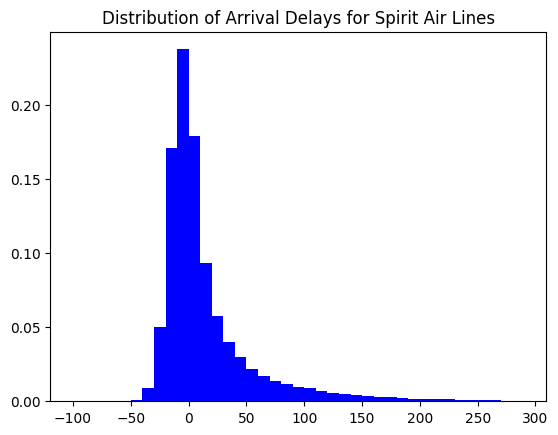

In [107]:
# Select an airline and visualize its flight delays

def plot_delays_by_airline(airline_name):
    adf = df[df["AIRLINE"] == airline_name]
    plot_values = adf["ARRIVAL_DELAY"].clip(-100, 300)
    delay_bins = range(-100, 300, 10)
    
    fig, ax = plt.subplots()
    ax.hist(plot_values, bins=delay_bins, weights=np.ones_like(plot_values)/len(plot_values), color="blue")
    ax.set_title(f"Distribution of Arrival Delays for {airline_name}")
    plt.show()
    
plot_delays_by_airline("Spirit Air Lines")  

In [108]:
# Correlation between flight distance and arrival delay

corr_df = df[['DISTANCE', 'ARRIVAL_DELAY']]

corr_df.corr(method='pearson')

,DISTANCE,ARRIVAL_DELAY
DISTANCE,1.00,-0.02
ARRIVAL_DELAY,-0.02,1.00


In [109]:
# We can also look at correlations by airline:

corr_df_2 = df[['AIRLINE', 'DISTANCE', 'ARRIVAL_DELAY']]

corr2 = corr_df_2.groupby('AIRLINE').agg('corr').xs('DISTANCE', level=1) 

corr2

,DISTANCE,ARRIVAL_DELAY
AIRLINE,,
Alaska Airlines Inc.,1.00,-0.11
American Airlines Inc.,1.00,-0.02
American Eagle Airlines Inc.,1.00,0.03
Atlantic Southeast Airlines,1.00,0.01
Delta Air Lines Inc.,1.00,-0.02
Frontier Airlines Inc.,1.00,-0.01
Hawaiian Airlines Inc.,1.00,0.06
JetBlue Airways,1.00,0.00
Skywest Airlines Inc.,1.00,0.01


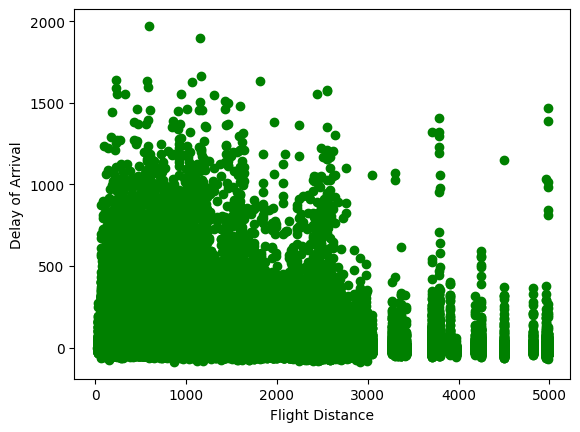

In [110]:
# A pairwise correlation is best visualized with a dotplot:

fig, ax = plt.subplots()
ax.scatter(df['DISTANCE'], df['ARRIVAL_DELAY'], color="green")
ax.set_xlabel("Flight Distance")
ax.set_ylabel("Delay of Arrival")
plt.show()

In [111]:
# Let's look at correlations between Departure Delay and Arrival Delay as well.
# Intuition tells us that these should be related, but sometimes 
#   a flight can save a lot of time in the air, so maybe not perfectly correlated

df[['DEPARTURE_DELAY', 'ARRIVAL_DELAY']].corr(method='pearson')

,DEPARTURE_DELAY,ARRIVAL_DELAY
DEPARTURE_DELAY,1.00,0.94
ARRIVAL_DELAY,0.94,1.00


In [112]:
# And by airport:

corr_df_3 = df[['AIRLINE', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

corr3 = corr_df_3.groupby('AIRLINE').agg('corr').xs('DEPARTURE_DELAY', level=1) 

corr3

,DEPARTURE_DELAY,ARRIVAL_DELAY
AIRLINE,,
Alaska Airlines Inc.,1.00,0.89
American Airlines Inc.,1.00,0.94
American Eagle Airlines Inc.,1.00,0.93
Atlantic Southeast Airlines,1.00,0.95
Delta Air Lines Inc.,1.00,0.94
Frontier Airlines Inc.,1.00,0.96
Hawaiian Airlines Inc.,1.00,0.94
JetBlue Airways,1.00,0.93
Skywest Airlines Inc.,1.00,0.95


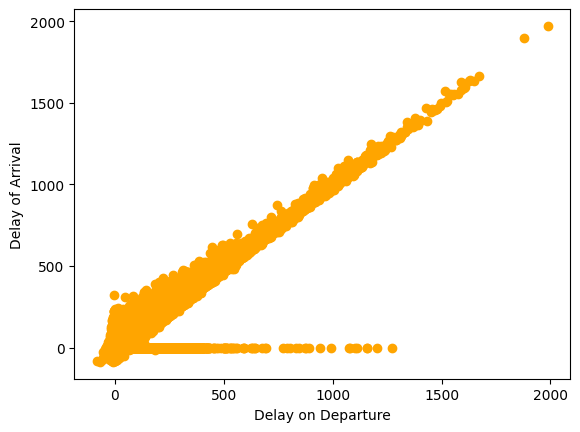

In [113]:
# What does this very high level of correlation look like?

fig, ax = plt.subplots()
ax.scatter(df['DEPARTURE_DELAY'], df['ARRIVAL_DELAY'], color="orange")
ax.set_xlabel("Delay on Departure")
ax.set_ylabel("Delay of Arrival")
plt.show()

In [114]:
# I'm curious about the cases where Depature Delay is 500 to 1000 minutes (10 to 20 hours)
#   but the Arrival Delay is very low.

outliers = df[(df['DEPARTURE_DELAY'] > 500) & (df['ARRIVAL_DELAY'] < 100)]

# How many cases have this issue?
outliers.shape[0]

43

In [115]:
# All of the cases in the head are flights which were diverted ('DIVERTED' == 1).

outliers.DIVERTED.describe()

count   43.00
mean     0.65
std      0.48
min      0.00
25%      0.00
50%      1.00
75%      1.00
max      1.00
Name: DIVERTED, dtype: float64

In [116]:
# Not all of these outliers are diverted flights, but 65% of them are.
# We could, therefore, slice those divtered cases out of the data.
# But, I'm not going to do that for a reason we will discuss later.

# Instead, let's consider predicting length of airline delay,
#   using the flight distance as a predictor
#   (i.e., do longer flights have longer delays?).

y = df['ARRIVAL_DELAY']
X = df['DISTANCE']

In [117]:
# Most scikit-learn functions accept y-inputs of type "array" with a shape of (number_of_samples, )
# But that is not what we currently have; y, because it was sliced from a data frame, 
#   is a one-column data frame

y = np.array(y)
y.shape

(5332914,)

In [118]:
# X and y are on such different scales, that it's useful to standardize X

X_norm = X.sub(X.mean()).div(X.std())

# Also, X needs to be an array with shape of (number_of_samples, number_of_features)
#   so that the same functions can act upon x and y

X_norm = np.array(X_norm).reshape(-1, 1)
X_norm

array([[1.02847203],
       [2.47960921],
       [2.42366968],
       ...,
       [1.27526407],
       [0.60234445],
       [1.23906791]], shape=(5332914, 1))

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42)

In [120]:
# One reason that Python is so popular for data science
#  is that the creation of a machine-learning model is as easy as this:

sgdr = SGDRegressor(max_iter=10000, random_state=42)
sgdr.fit(X_train, y_train)
print(sgdr)

SGDRegressor(max_iter=10000, random_state=42)


In [121]:
# Calculate the Mean Squared Error, to compare with other models we're about to create

y_pred = sgdr.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print(f"MSE of first model: {int(mse)}")

MSE of first model: 1550


In [122]:
# Now compare with Departure Delay predicting Arrival Delay

X2 = df['DEPARTURE_DELAY']
X2_norm = X2.sub(X2.mean()).div(X2.std())
X2_norm = np.array(X2_norm).reshape(-1, 1)
X2_norm

array([[-0.55260983],
       [-0.47221442],
       [-0.3114236 ],
       ...,
       [-0.49901289],
       [-0.41861748],
       [ 0.14415039]], shape=(5332914, 1))

In [123]:
X2_train, X2_test, y_train, y_test = train_test_split(X2_norm, y, test_size=0.3, random_state=42)

In [124]:
sgdr2 = SGDRegressor(max_iter=10000, random_state=42)
sgdr2.fit(X2_train, y_train)
print(sgdr2)

SGDRegressor(max_iter=10000, random_state=42)


In [125]:
y2_pred = sgdr2.predict(X2_test)
mse2 = mean_squared_error(y_test,y2_pred)
print(f"MSE of second model: {int(mse2)}")

MSE of second model: 184


In [126]:
# The MSE has improved by an order of magnitude, compared to model 1.

# But we need to worry that model 2 overfits the data because the correlation 
#   between DEPARTURE_DELAY and ARRIVAL_DELAY is so high. This is why we 
#   did not get rid of the diverted flights; that would make the correlation 
#   (and thus the odds of overfitting) even higher.

# So, it's worth asking what happens if we make a model that involves both variables

X3 = df[['DEPARTURE_DELAY', 'DISTANCE']]
X3.shape

(5332914, 2)

In [127]:
# The more efficient way to standardize when data are in a matrix or data frame
#   is to use the preprocessing method StandardScaler()

scaler = StandardScaler()
X3_norm = scaler.fit_transform(X3) 
X3_norm

array([[-0.55260989,  1.02847213],
       [-0.47221447,  2.47960944],
       [-0.31142363,  2.42366991],
       ...,
       [-0.49901294,  1.27526419],
       [-0.41861752,  0.60234451],
       [ 0.1441504 ,  1.23906802]], shape=(5332914, 2))

In [128]:
X3_train, X3_test, y_train, y_test = train_test_split(X3_norm, y, test_size=0.3, random_state=42)

In [129]:
sgdr3 = SGDRegressor(max_iter=10000, random_state=42)
sgdr3.fit(X3_train, y_train)
print(sgdr3)

SGDRegressor(max_iter=10000, random_state=42)


In [130]:
y3_pred = sgdr3.predict(X3_test)
mse3 = mean_squared_error(y_test,y3_pred)
print(f"MSE of combined model: {int(mse3)}")

MSE of combined model: 180


In [131]:
# We actually gain a small amount of MSE value!

# This is good proof that model 2 overfits the data; we added a feature to it that has 
#   no correlation at all with y, yet we have improved the performance over model 2

In [132]:
# Regardless of whether we can predict Delay Length at all,
#   we might be able to predict the existence of a delay or not

df['DELAY_EXISTS'].describe()

count   5332914.00
mean          0.36
std           0.48
min           0.00
25%           0.00
50%           0.00
75%           1.00
max           1.00
Name: DELAY_EXISTS, dtype: float64

In [133]:
# A flight is delayed on arrival 36% of the time. Because this is a binary variable
#   (values are either 1 or 0 only), we can predict it with logistic regression

yy = df['DELAY_EXISTS']
XX = df['DISTANCE']

In [134]:
yy = np.array(yy)
yy.shape

(5332914,)

In [135]:
XX_norm = XX.sub(XX.mean()).div(XX.std())
XX_norm = np.array(XX_norm).reshape(-1, 1)
XX_norm

array([[1.02847203],
       [2.47960921],
       [2.42366968],
       ...,
       [1.27526407],
       [0.60234445],
       [1.23906791]], shape=(5332914, 1))

In [136]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX_norm, yy, test_size=0.3, random_state=42)

In [137]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42)
lr_model.fit(XX_train, yy_train)

LogisticRegression(random_state=42)

In [138]:
yy_pred = lr_model.predict(XX_test)

In [139]:
# We can view the accuracy, along with other statistics, with classification_report()

from sklearn.metrics import classification_report
print(classification_report(yy_test, yy_pred))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78   1016310
           1       0.00      0.00      0.00    583565

    accuracy                           0.64   1599875
   macro avg       0.32      0.50      0.39   1599875
weighted avg       0.40      0.64      0.49   1599875



/Users/markyoung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/markyoung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/markyoung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
# 0.64 is good accuracy out of context, but the report shows there is a problem:
#   we are predicting "delay" (y_test = 1) with 0% precision.
#   (That's the reason for the errors above.)
# Thus, the model predicts "no delay" (y_test = 0) well, but that's it.

# Let's see what happens when we add Departure Delay to the model:

XX2 = df[['DEPARTURE_DELAY', 'DISTANCE']]
XX2.shape


(5332914, 2)

In [141]:
scaler = StandardScaler()
XX2_norm = scaler.fit_transform(XX2) 
XX2_norm

array([[-0.55260989,  1.02847213],
       [-0.47221447,  2.47960944],
       [-0.31142363,  2.42366991],
       ...,
       [-0.49901294,  1.27526419],
       [-0.41861752,  0.60234451],
       [ 0.1441504 ,  1.23906802]], shape=(5332914, 2))

In [142]:
XX2_train, XX2_test, yy_train, yy_test = train_test_split(XX2_norm, yy, test_size=0.3, random_state=42)

In [143]:
lr2 = LogisticRegression(random_state=42)
lr2.fit(XX2_train, yy_train)

LogisticRegression(random_state=42)

In [144]:
yy2_pred = lr2.predict(XX2_test)

In [145]:
print(classification_report(yy_test, yy2_pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87   1016310
           1       0.88      0.60      0.71    583565

    accuracy                           0.82   1599875
   macro avg       0.84      0.78      0.79   1599875
weighted avg       0.83      0.82      0.82   1599875



In [146]:
# Much better! There's still a dramatic drop in recall when we are predicting 1 instead of 0,
#   but this is a big improvement.

# Another effective approach when the amount of 1s in the dataset is low, 
#   is to use a Decision Tree model. 

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42).fit(XX2_train, yy_train)

In [147]:
pred_tree = model.predict(XX2_test)

In [148]:
print(classification_report(yy_test, pred_tree))

# We see a slight improvement in accuracy for predicting delay_exists = 1.

              precision    recall  f1-score   support

           0       0.81      0.95      0.87   1016310
           1       0.87      0.61      0.72    583565

    accuracy                           0.83   1599875
   macro avg       0.84      0.78      0.80   1599875
weighted avg       0.83      0.83      0.82   1599875

